# Syft Duet - Data Scientist 

## PART 1: Connect to a Remote Duet Server

As the Data Scientist, you want to perform data science on data that is sitting in the Data Owner's Duet server in their Notebook.

In order to do this, we must run the code that the Data Owner sends us, which importantly includes their Duet Session ID. The code will look like this, importantly with their real Server ID.

```
import syft as sy
duet = sy.duet('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')
```

This will create a direct connection from my notebook to the remote Duet server. Once the connection is established all traffic is sent directly between the two nodes.

Paste the code or Server ID that the Data Owner gives you and run it in the cell below. It will return your Client ID which you must send to the Data Owner to enter into Duet so it can pair your notebooks.


Please do not run ```duet``` blocks from ```Duet_FL_Data_Owner_1_Alice``` and ```Duet_FL_Data_Owner_2_Bob``` "Simultaneously".  
The sequence of runs is:  
* 1. Go to ```Duet_FL_Data_Owner_1_Alice``` file and run its ```duet``` block
* 2. Back to ```Duet_FL_Data_Scientist``` file and run its ```duet1``` block
* 3. Go to ```Duet_FL_Data_Owner_2_Bob``` file and run its ```duet``` block
* 4. Back to ```Duet_FL_Data_Scientist``` file and run  its ```duet2``` block


In [1]:
import syft as sy
#Alice
duet1 = sy.join_duet(loopback=True)

🎤  🎸  ♪♪♪ Joining Duet ♫♫♫  🎻  🎹

♫♫♫ > DISCLAIMER: Duet is an experimental feature currently in beta.
♫♫♫ > Use at your own risk.


    > ❤️ Love Duet? Please consider supporting our community!
    > https://github.com/sponsors/OpenMined

♫♫♫ > Punching through firewall to OpenGrid Network Node at:
♫♫♫ > http://ec2-18-218-7-180.us-east-2.compute.amazonaws.com:5000
♫♫♫ >
♫♫♫ > ...waiting for response from OpenGrid Network... 
♫♫♫ > DONE!


/home/fjunyuan/.local/lib/python3.8/site-packages/aiortc/rtcdtlstransport.py:211: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  _openssl_assert(lib.SSL_CTX_use_certificate(ctx, self._cert._x509) == 1)  # type: ignore
/home/fjunyuan/.local/lib/python3.8/site-packages/aiortc/rtcdtlstransport.py:186: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  value=certificate_digest(self._cert._x509),  # type: ignore



♫♫♫ > CONNECTED!


In [2]:
#Bob
duet2 = sy.join_duet(loopback=True)# Part 2: Search for Available Data


🎤  🎸  ♪♪♪ Joining Duet ♫♫♫  🎻  🎹

♫♫♫ > DISCLAIMER: Duet is an experimental feature currently in beta.
♫♫♫ > Use at your own risk.


    > ❤️ Love Duet? Please consider supporting our community!
    > https://github.com/sponsors/OpenMined

♫♫♫ > Punching through firewall to OpenGrid Network Node at:
♫♫♫ > http://ec2-18-218-7-180.us-east-2.compute.amazonaws.com:5000
♫♫♫ >
♫♫♫ > ...waiting for response from OpenGrid Network... 
♫♫♫ > DONE!

♫♫♫ > CONNECTED!


Now you can go back to ```Duet_FL_Data_Owner_1_Alice``` and ```Duet_FL_Data_Owner_2_Bob``` and run the rest of the code there.  
Since everything is finished you can back to here.

# Part 2: Search and point for Available Data


In [3]:
# The data scientist can check the list of searchable data in Data Owner's duet store
duet1.store.pandas

,ID,Tags,Description,object_type
0,<UID: c3fc9396ba2f4646bd5df9e82b75cd42>,[Bob_iris-data],This is a dataset for flower classification of...,<class 'torch.Tensor'>
1,<UID: 3a8edd9141064106b504887f3120008c>,[Bob_iris-target],"Labels for flowers: Iris-setosa, Iris-versicol...",<class 'torch.Tensor'>


In [4]:
duet2.store.pandas

,ID,Tags,Description,object_type
0,<UID: 75cd6246ecb84b9eb4b91d9d0cfe1d11>,[Alice_iris-data],This is a dataset for flower classification of...,<class 'torch.Tensor'>
1,<UID: 3470eff444fb47d8adbd497582b6b303>,[Alice_iris-target],"Labels for flowers: Iris-setosa, Iris-versicol...",<class 'torch.Tensor'>


Data Scientist wants to use the iris dataset. But (S)He can not directly access to data. (S)He needs a pointer to the data(feature) and a pointer to the target(label) for prediction.

## In this notebook we assume ```data_owner1``` =```Alice``` and ```data_owner2``` = ```Bob```

In [5]:
# Pointers for Alice
data1_ptr = duet1.store[0]#"Alice_iris-data" or "Bob_iris-data" depends on the order you ran it 
target1_ptr = duet1.store[1]#"Alice_iris-target" or "Bob_iris-target"

`data_ptr` is a reference to the iris dataset remotely available on data owner's server.
`target_ptr` is a reference to the iris dataset LABELS remotely available on data owner's server

In [6]:
# Pointers for Bob
data2_ptr = duet2.store[0]
target2_ptr = duet2.store[1]

In [7]:
print(data1_ptr)
print(target1_ptr)
print(data2_ptr)
print(target2_ptr)

## PART 3: Setting up a Model
The model we use is MLP

First, let's create our model for `MLP`. We do this in almost the exact same way as in PyTorch. The main difference is we inherit from sy.Module instead of nn.Module and we need to pass in a variable called torch_ref which we will use internally for any calls that would normally be to torch.

In [8]:
class SyNet(sy.Module):
    def __init__(self, torch_ref):
        #继承父类 sy.Module
        super(SyNet, self).__init__(torch_ref=torch_ref)
        self.layer1 = self.torch_ref.nn.Linear(in_dim, 20)
        self.layer2 = self.torch_ref.nn.Linear(20, 30)
        self.layer3 = self.torch_ref.nn.Linear(30, 30)
        self.out = self.torch_ref.nn.Linear(30, out_dim)

    def forward(self, x):
        x = self.torch_ref.nn.functional.relu(self.layer1(x))
        x = self.torch_ref.nn.functional.relu(self.layer2(x))
        x = self.torch_ref.nn.functional.relu(self.layer3(x))
        output = self.torch_ref.nn.functional.log_softmax(self.out(x), dim=1)
        return output


## PART 4: Perform MLP on Iris dataset
Now the data scientist can perform machine learning on the data that is in the Data Owner's duet server, without the owner having to share his/her data.

### Basic analysis

First the data scientist needs to know some basic information about the dataset.
1. The length of the dataset
2. The input dimension
3. The output dimension

These information have to be explicitly shared by the Data Owner. Let's try to find them in the data description.

In [9]:
print(duet1.store.pandas["Description"][0])
print()
print(duet1.store.pandas["Description"][1])

This is a dataset for flower classification of 80 samples. 4 Features are sepal length (cm),sepal width (cm), petal length (cm), petal width (cm)

Labels for flowers: Iris-setosa, Iris-versicolour, Iris-virginica


In [10]:
print(duet2.store.pandas["Description"][0])
print()
print(duet2.store.pandas["Description"][1])

This is a dataset for flower classification of 70 samples. 4 Features are sepal length (cm),sepal width (cm), petal length (cm), petal width (cm)

Labels for flowers: Iris-setosa, Iris-versicolour, Iris-virginica


In [11]:
#After analysing, let us set data dimension and data size values as global
in_dim = 4
out_dim = 3
n_samples_Alice = 70
n_samples_Bob = 80

### Training

#### 1.Send one copy of the model to each data owner or client 
#### 2.Train them remotely one by one

In [15]:
import torch

#### 1.Send one copy of the model to each data owner or client 

Now we can create a local model by passing our local copy of torch.

In [16]:
base_model = SyNet(torch)

##### Data Owner 1 -- Alice

In [17]:
remote_model1 = base_model.send(duet1)

Let's create an alias for our partner’s torch called `remote_torch` so we can refer to the local torch as torch and any operation we want to do remotely as `remote_torch`. Remember, the return values from `remote_torch` are Pointers, not the real objects. They mostly act the same when using them with other Pointers but they cannot be mixed with local torch objects.  

Then we will get a pointer to our remote model parameters. Then we will set our optimizer. Here, we will be using `Adam optimizer`. `params` is a pointer to the list of parameters. `optim` is a reference to the Adam optimizer which can be used to optimize the remote model.

In [18]:
remote_torch1 = duet1.torch
params1 = remote_model1.parameters()
optim1 = remote_torch1.optim.Adam(params=params1, lr=0.1)

###### Data Owner 2 -- Bob

In [19]:
remote_model2 = base_model.send(duet2)

In [20]:
remote_torch2 = duet2.torch
params2 = remote_model2.parameters()
optim2 = remote_torch2.optim.Adam(params=params2, lr=0.1)

#### Train them remotely one by one

Now we will create our `train` function. It will take few parameters, like the `remote_model`, `torch_ref`, `optim` and `data_ptr` and `target_ptr`.

In [21]:
def train(iterations, model, torch_ref, optim, data_ptr, target_ptr):

    losses = []

    for i in range(iterations):
        
        # 1) erase previous gradients (if they exist)
        optim.zero_grad()
        
        # 2) make a prediction
        output = model(data_ptr)
        
        # 3) calculate how much we missed
        # nll_loss = negative log-liklihood loss
        # if use mse, returns None because our model's output layer uses "nn.functional.log_softmax"
        loss = torch_ref.nn.functional.nll_loss(output, target_ptr.long())
        
        # loss items
        #########################################
        loss_item = loss.item()
        
        #during training keep track of the loss.
        #we need to ask for the loss item from the data owner, because it is training remotely on his machine
        loss_value = loss_item.get(
            reason="To evaluate training progress", 
            request_block=True, 
            timeout_secs=5
        )

        print("Epoch", i, "loss", loss_value)

        losses.append(loss_value)
        #########################################
        
        # 4) figure out which weights caused us to miss
        loss.backward()
        
        # 5) change those weights
        optim.step()

    return losses

###### Data Owner 1 -- Alice

Train on Data Owner 1 data

In [22]:
iteration = 10
losses1 = train(iteration, remote_model1, remote_torch1, optim1, data1_ptr, target1_ptr)

Epoch 0 loss 1.062825083732605
Epoch 1 loss 0.7082244157791138
Epoch 2 loss 3.9934134483337402
Epoch 3 loss 1.3003758192062378
Epoch 4 loss 0.6861977577209473
Epoch 5 loss 0.8324025273323059
Epoch 6 loss 0.8585746884346008
Epoch 7 loss 0.8087603449821472
Epoch 8 loss 0.7466453313827515
Epoch 9 loss 0.7464252710342407


In [23]:
#target1_ptr.get(request_block=True, delete_obj=False)

Text(0.5, 0, 'iteration')

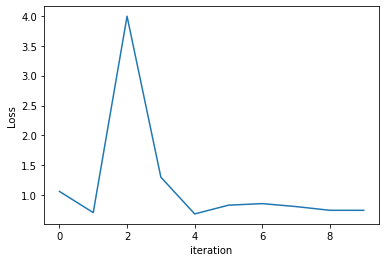

In [24]:
import matplotlib.pyplot as plt
plt.plot(range(iteration), losses1)
plt.ylabel("Loss")
plt.xlabel("iteration")

###### Data Owner 2 -- Bob

Train on Data Owner 2 data

In [25]:
iteration = 10
losses2 = train(iteration, remote_model2, remote_torch2, optim2, data2_ptr, target2_ptr)

Epoch 0 loss 1.167180061340332
Epoch 1 loss 1.3690968751907349
Epoch 2 loss 0.8800439238548279
Epoch 3 loss 0.8253083825111389
Epoch 4 loss 0.68745356798172
Epoch 5 loss 0.6503481268882751
Epoch 6 loss 0.5672250986099243
Epoch 7 loss 0.47517743706703186
Epoch 8 loss 0.42719778418540955
Epoch 9 loss 0.23246146738529205


Text(0.5, 0, 'iteration')

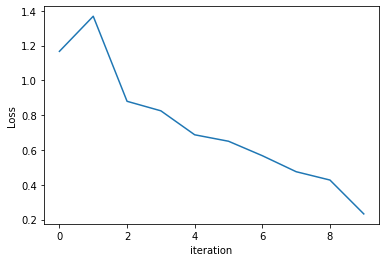

In [26]:
plt.plot(range(iteration), losses2)
plt.ylabel("Loss")
plt.xlabel("iteration")

## PART 5: Averaging Model Updates

Ideally, there will be a coordinator server with a secure aggreagtor who will get the model updates from different clients and make an aggregation. For the case of simplicity, in this example we will make the Data Sceintist server work as the coordinator.

### Little sanity check!

In [27]:
param1 = remote_model1.parameters().get(request_block=True)
param2 = remote_model2.parameters().get(request_block=True)

# print("Base Model parameters:")
# print(base_model.parameters())
#weights, bias

In [28]:
# print("Remote model1 parameters:")
# print(param1)

In [29]:
# print("Remote model2 parameters:")
# print(param2)

As you can see, the remote model paramter values are different from the base model paramter values. That means the remote copies of our base model got trained and updated.

In [30]:
remote_model1_updates = remote_model1.get(
    request_block=True
).state_dict()

In [56]:
remote_model1.get(
    request_block=True
).parameters();

In [32]:
remote_model2_updates = remote_model2.get(
    request_block=True
).state_dict()

In [33]:
from collections import OrderedDict

Let's do the aggregation of the weights. In this example, we will just calculate the average of corresponding weights from each model.  
Here we have ```layer1.weight```, ```layer1.bias```, ```layer2.weight```, ```layer2.bias```, ```layer3.weight```, ```layer3.bias```

In [34]:
remote_model1_updates["layer1.bias"]

tensor([ 0.4852, -0.1751,  0.0489, -0.1555, -0.2250, -0.1857, -0.4386, -0.3316,
        -0.4379,  0.3310, -0.3835, -0.8033, -0.0876, -0.0189,  0.0797, -0.4238,
        -0.4885, -0.0413, -0.4268, -0.3395])

# Aggrigator: FederatedAveraging method FedAvg

In [35]:
from IPython.display import Image
Image(url= "FedAvg.jpg", width=800, height=800)

In [36]:
#layer1.weight, layer1.bias, layer2.weight, layer2.bias, layer3.weight, layer3.bias
avg_updates = OrderedDict()
#data_size is 150All = 80Bob + 70Alice

avg_updates["layer1.weight"] = (
    remote_model1_updates["layer1.weight"]*80 + remote_model2_updates["layer1.weight"]*70
)/150
avg_updates["layer1.bias"] = (
    remote_model1_updates["layer1.bias"]*80 + remote_model2_updates["layer1.bias"]*70
)/150

avg_updates["layer2.weight"] = (
    remote_model1_updates["layer2.weight"]*80 + remote_model2_updates["layer2.weight"]*70
) /150
avg_updates["layer2.bias"] = (
    remote_model1_updates["layer2.bias"]*80 + remote_model2_updates["layer2.bias"]*70
) /150
avg_updates["layer3.weight"] = (
    remote_model1_updates["layer3.weight"]*80 + remote_model2_updates["layer3.weight"]*70
) /150
avg_updates["layer3.bias"] = (
    remote_model1_updates["layer3.bias"]*80 + remote_model2_updates["layer3.bias"]*70
) /150

#print(avg_updates)

### Load aggregated weights

In [37]:
combined_model = SyNet(torch)

In [38]:
combined_model.load_state_dict(avg_updates)

In [39]:
del avg_updates, remote_model1_updates, remote_model2_updates

### Test 

In [40]:
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

In [41]:
iris_test = pd.read_csv("./data/iris-test.csv")
iris_test.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.8,4.0,1.2,0.2,0
1,5.7,4.4,1.5,0.4,0
2,6.0,2.7,5.1,1.6,1
3,6.0,2.9,4.5,1.5,1
4,5.8,2.7,5.1,1.9,2


In [42]:
X_test = iris_test.loc[:, iris_test.columns != "species"]
y_test = iris_test["species"]
X_test = torch.FloatTensor(np.array(X_test))
y_test = torch.LongTensor(np.array(y_test))

### FedAvg model

In [43]:
local_model = combined_model

In [44]:
preds = []
with torch.no_grad():
    for i in range(len(X_test)):
        sample = X_test[i]
        y_hat = local_model(sample.unsqueeze(0))
        pred = y_hat.argmax().item()#因为likelihood / probability 所以argmax
        #print(f"Prediction: {pred} Ground Truth: {y_test[i]}")
        preds.append(pred)

In [45]:
print(preds)

[0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1]


In [46]:
acc = accuracy_score(y_test, preds)
print("Overall test accuracy", acc * 100)

Overall test accuracy 60.0


### Download model

In [47]:
def get_local_model(model):
    if not model.is_local:
        local_model = model.get(
            request_block=True,
            reason="To run test and inference locally",
            timeout_secs=5,
        )
        print("it is not the local model")
    else:
        local_model = model
        print("it is the local model")

    return local_model


### Alice model

In [48]:
local_model = get_local_model(remote_model1)

it is not the local model


In [49]:
preds = []
with torch.no_grad():
    for i in range(len(X_test)):
        sample = X_test[i]
        y_hat = local_model(sample.unsqueeze(0))
        pred = y_hat.argmax().item()#because of the "log_softmax" so argmax
        #print(f"Prediction: {pred} Ground Truth: {y_test[i]}")
        preds.append(pred)

In [50]:
print(preds)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [51]:
acc = accuracy_score(y_test, preds)
print("Overall test accuracy", acc * 100)

Overall test accuracy 40.0


### Bob model

In [52]:
local_model = get_local_model(remote_model2)

it is not the local model


In [53]:
preds = []
with torch.no_grad():
    for i in range(len(X_test)):
        sample = X_test[i]
        y_hat = local_model(sample.unsqueeze(0))
        pred = y_hat.argmax().item()#because of the "log_softmax" so argmax
        #print(f"Prediction: {pred} Ground Truth: {y_test[i]}")
        preds.append(pred)

In [54]:
print(preds)

[0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1]


In [55]:
acc = accuracy_score(y_test, preds)
print("Overall test accuracy", acc * 100)

Overall test accuracy 60.0
